<a href="https://colab.research.google.com/github/AlexeyK12/Implementation-of-the-article-StyleGAN-NADA/blob/main/app_StyleGAN_NADA_AK_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

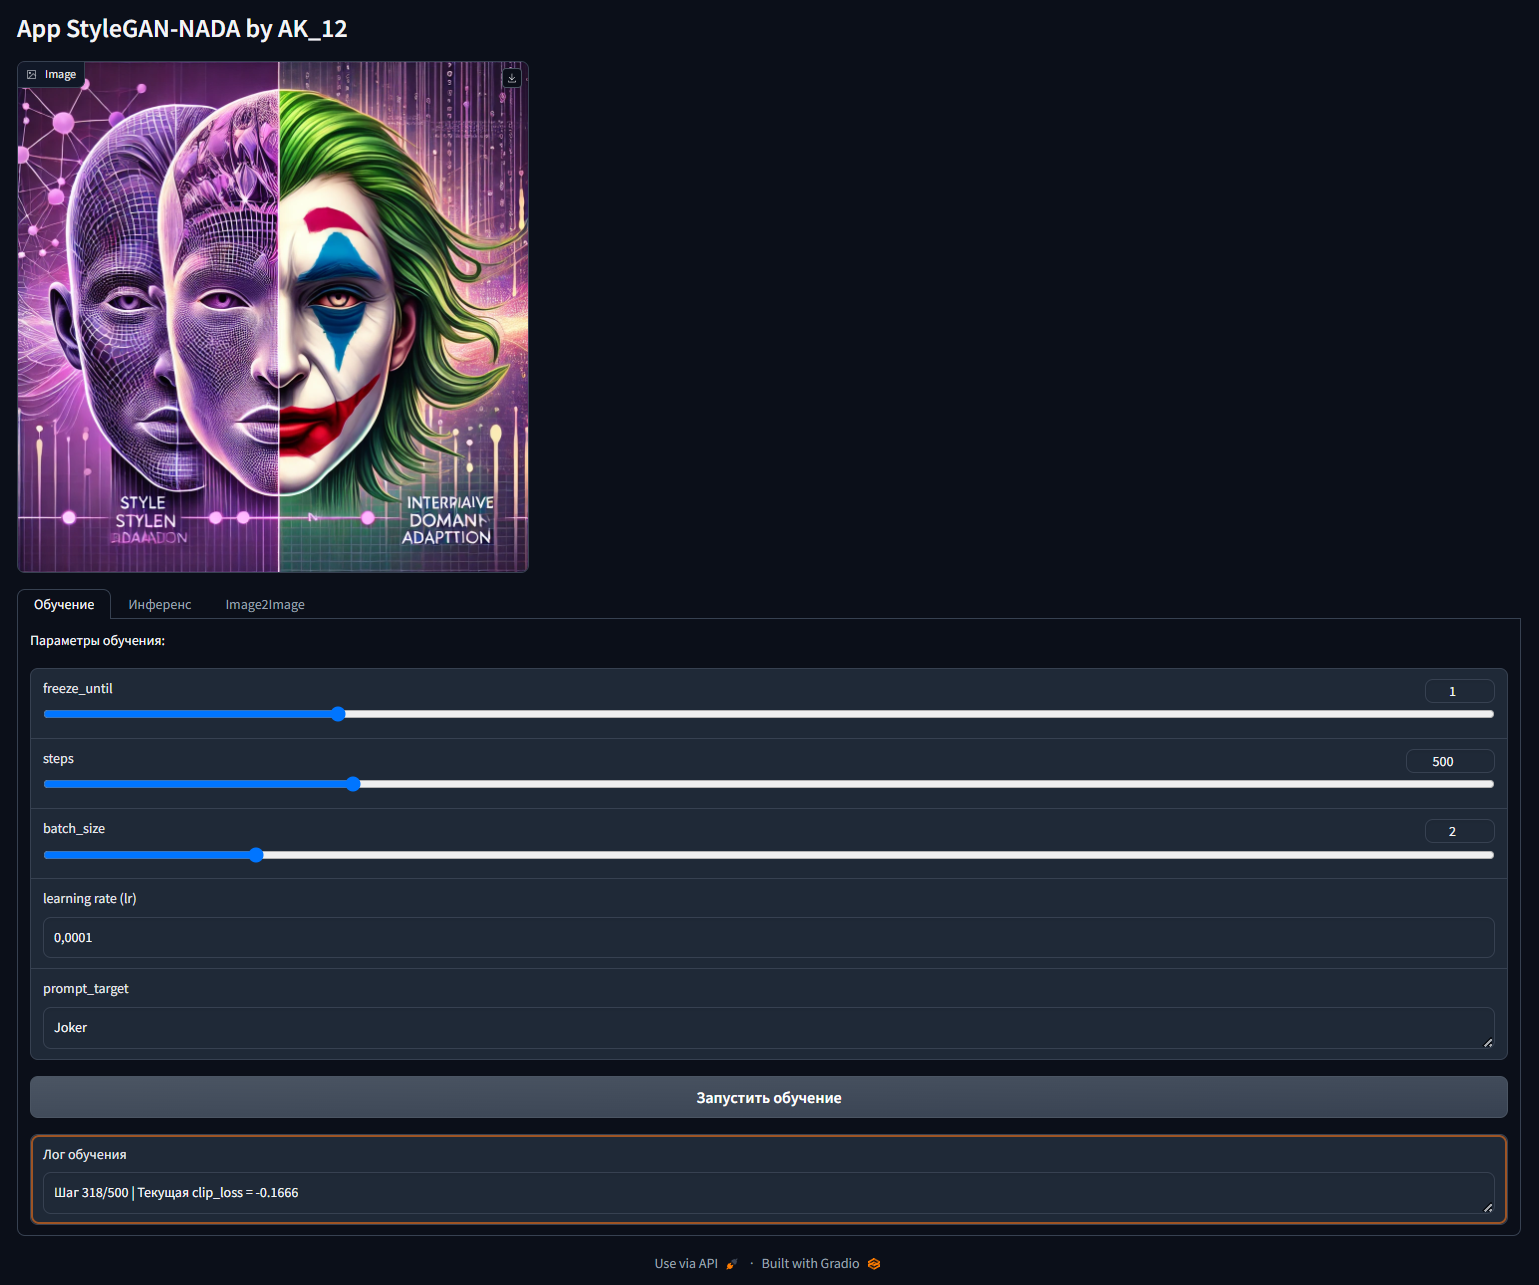

In [10]:
from IPython.display import Image
Image(filename='/content/app_img.png')

In [11]:
#########################
# УСТАНОВКА ЗАВИСИМОСТЕЙ
#########################

!nvidia-smi

#!pip uninstall google-genai -y
#!pip install gradio

import os
os.environ["TORCH_CUDA_ARCH_LIST"] = "7.5"

!apt-get -y install ninja-build
!pip install git+https://github.com/openai/CLIP.git
!pip install gradio==3.39.0

if not os.path.exists("Article-implementation-StyleGAN-NADA"):
    !git clone https://github.com/AlexeyK12/Article-implementation-StyleGAN-NADA.git

if not os.path.exists("stylegan2-ffhq-config-f.pt"):
    !wget https://huggingface.co/akhaliq/OneshotCLIP-stylegan2-ffhq/resolve/main/stylegan2-ffhq-config-f.pt -O stylegan2-ffhq-config-f.pt

%cd Article-implementation-StyleGAN-NADA

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


import torch.nn.functional as F
import numpy as np
from PIL import Image
import gradio as gr

from model import Generator
import clip

import os
from tqdm import tqdm

import gradio as gr

outdir = "/content/outputs_nada_colab"
os.makedirs(outdir, exist_ok=True)




########################
# ИНИЦИАЛИЗАЦИЯ ФУНКЦИЙ
########################

# загрузка CLIP
clip_model, _ = clip.load("ViT-B/32", device=device)
clip_model.eval().requires_grad_(False)

# загрузка StyleGAN2
ckpt_path_base = "/content/stylegan2-ffhq-config-f.pt"

latent_dim = 512
image_size = 1024

base_generator = Generator(
    size=image_size,
    style_dim=latent_dim,
    n_mlp=8,
    channel_multiplier=2
).to(device)

ckpt = torch.load(ckpt_path_base, map_location=device)
base_generator.load_state_dict(ckpt["g_ema"], strict=False)

def copy_generator(src_gen):
    import copy
    new_gen = Generator(
    size=image_size,
    style_dim=latent_dim,
    n_mlp=8,
    channel_multiplier=2
    ).to(device)

    new_gen.load_state_dict(src_gen.state_dict(), strict=False)
    return new_gen

# заморозка coarse-слоёв
def freeze_layers(g, freeze_num=2):
    blocks_to_freeze = freeze_num * 2
    for i, conv_block in enumerate(g.convs):
        if i < blocks_to_freeze:
            for param in conv_block.parameters():
                param.requires_grad = False
    for i, to_rgb_layer in enumerate(g.to_rgbs):
        if i < freeze_num:
            for param in to_rgb_layer.parameters():
                param.requires_grad = False
    return g

# предобработка для CLIP
def clip_preprocess_tensor(imgs):
    imgs = (imgs.clamp(-1,1) + 1)/2
    imgs_224 = F.interpolate(imgs, size=(224, 224), mode='bilinear', align_corners=False)
    clip_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device).view(1, -1, 1, 1)
    clip_std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1, -1, 1, 1)
    imgs_224 = (imgs_224 - clip_mean) / clip_std
    return imgs_224

# сохранение модели
def save_checkpoint(gen, path):
    torch.save({"g_ema": gen.state_dict()}, path)

# функция обучения
def train_model(
    freeze_until=1,
    steps=500,
    batch_size=2,
    lr=1e-4,
    prompt_target="joker"
):
    generator = copy_generator(base_generator)
    generator.train()

    # замораживаем слои
    generator = freeze_layers(generator, freeze_num=freeze_until)

    # текстовые эмбеддинги
    prompt_orig = "face"
    text_orig_emb = clip_model.encode_text(clip.tokenize(prompt_orig).to(device))
    text_target_emb = clip_model.encode_text(clip.tokenize(prompt_target).to(device))
    text_orig_emb   = text_orig_emb / text_orig_emb.norm(dim=-1, keepdim=True)
    text_target_emb = text_target_emb / text_target_emb.norm(dim=-1, keepdim=True)

    params_to_optimize = [p for p in generator.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params_to_optimize, lr=lr, betas=(0.0, 0.99))

    alpha = 0.5

    # цикл обучения
    pbar = range(steps)
    for step_i in pbar:
        optimizer.zero_grad()

        z = torch.randn(batch_size, latent_dim, device=device)
        generated_imgs, _ = generator([z], truncation=1, input_is_latent=False)

        clip_in = clip_preprocess_tensor(generated_imgs)
        image_embeds = clip_model.encode_image(clip_in)
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)

        target_sim = (image_embeds * text_target_emb).sum(dim=-1)
        orig_sim   = (image_embeds * text_orig_emb).sum(dim=-1)

        clip_loss = - (target_sim - alpha * orig_sim).mean()
        clip_loss.backward()
        optimizer.step()

        yield f"Шаг {step_i+1}/{steps} | Текущая clip_loss = {clip_loss.item():.4f}"

    final_ckpt_path = os.path.join(outdir, "stylegan2_nada_final.pt")
    save_checkpoint(generator, final_ckpt_path)

    yield f"Обучение завершено!\nФинальный чекпоинт сохранён по пути: {final_ckpt_path}"

# функция инференса
def infer_model():
    final_ckpt_path = os.path.join(outdir, "stylegan2_nada_final.pt")
    if not os.path.exists(final_ckpt_path):
        return [Image.new("RGB", (256, 256), color=(180, 0, 0))]

    gen_for_infer = copy_generator(base_generator)
    checkpoint = torch.load(final_ckpt_path, map_location=device)
    gen_for_infer.load_state_dict(checkpoint["g_ema"], strict=False)
    gen_for_infer.eval()

    result_images = []
    with torch.no_grad():
        for _ in range(5):
            z = torch.randn(1, latent_dim, device=device)
            img, _ = gen_for_infer([z], truncation=1, input_is_latent=False)
            img = (img.clamp(-1, 1) + 1) / 2
            img = (img * 255).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)[0]
            pil_img = Image.fromarray(img)

            scale_factor = 1/3
            w, h = pil_img.size
            new_w, new_h = int(w*scale_factor), int(h*scale_factor)
            pil_img_small = pil_img.resize((new_w, new_h), Image.LANCZOS)

            result_images.append(pil_img_small)
    return result_images


# инверсия
def invert_image(img: Image.Image, generator, steps=300, lr=0.01):
    generator.eval()

    img_t = torch.from_numpy(np.array(img)).float().to(device) / 255.0
    if len(img_t.shape) == 3:
        img_t = img_t.permute(2, 0, 1).unsqueeze(0)
    img_t = img_t * 2 - 1
    img_t = F.interpolate(img_t, size=(1024, 1024), mode='bilinear', align_corners=False)

    z_opt = torch.randn(1, latent_dim, device=device, requires_grad=True)

    optimizer = torch.optim.Adam([z_opt], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()
        gen_img, _ = generator([z_opt], truncation=1, input_is_latent=False)

        loss = F.mse_loss(gen_img, img_t)
        loss.backward()
        optimizer.step()

    return z_opt.detach()


def transform_image(input_img: Image.Image):
    try:
        outdir = "/content/outputs_nada_colab"
        final_ckpt_path = os.path.join(outdir, "stylegan2_nada_final.pt")
        if not os.path.exists(final_ckpt_path):
            return Image.new("RGB", (256, 256), color=(255, 0, 0))

        gen_for_infer = copy_generator(base_generator)
        checkpoint = torch.load(final_ckpt_path, map_location=device)
        gen_for_infer.load_state_dict(checkpoint["g_ema"], strict=False)
        gen_for_infer.to(device).eval()

        z_approx = invert_image(input_img, gen_for_infer, steps=300, lr=0.01)

        with torch.no_grad():
            gen_img, _ = gen_for_infer([z_approx], truncation=1, input_is_latent=False)

        gen_img = (gen_img.clamp(-1, 1) + 1) * 0.5
        gen_img = gen_img.mul(255).byte().permute(0, 2, 3, 1).cpu().numpy()
        pil_img = Image.fromarray(gen_img[0], 'RGB')

        scale_factor = 1/4
        w, h = pil_img.size
        pil_img_small = pil_img.resize((int(w*scale_factor), int(h*scale_factor)), Image.LANCZOS)

        return pil_img_small

    except Exception as e:
        print("Ошибка внутри transform_image:", str(e))
        raise e




####################
# ПРИЛОЖЕНИЕ GRADIO
####################

with gr.Blocks() as demo:
    gr.Markdown("# App StyleGAN-NADA by AK_12")

    gr.Image(
        value="/content/Article-implementation-StyleGAN-NADA/DALL·E-hum-joker.png",
        interactive=False,
        label="",
        width=512,
        height=512
    )

    with gr.Tab("Обучение"):
        gr.Markdown("Параметры обучения:")
        freeze_slider   = gr.Slider(minimum=0, maximum=5, step=1, value=1, label="freeze_until")
        steps_slider    = gr.Slider(minimum=100, maximum=2000, step=50, value=500, label="steps")
        batch_slider    = gr.Slider(minimum=1, maximum=8, step=1, value=2, label="batch_size")
        lr_number       = gr.Number(value=1e-4, label="learning rate (lr)")
        prompt_target_t = gr.Textbox(value="joker", label="prompt_target")

        train_btn = gr.Button("Запустить обучение")
        train_output = gr.Textbox(label="Лог обучения")

        train_btn.click(
            fn=train_model,
            inputs=[freeze_slider, steps_slider, batch_slider, lr_number, prompt_target_t],
            outputs=train_output
        )

    with gr.Tab("Инференс"):
        gr.Markdown("Генерация 5 изображений с обученной моделью по промту")
        infer_btn = gr.Button("Генерировать")
        gallery = gr.Gallery(label="Сгенерированные изображения", show_label=False).style(grid=[5], height="auto")

        infer_btn.click(
            fn=infer_model,
            inputs=[],
            outputs=gallery
        )

    with gr.Tab("Image2Image"):
        gr.Markdown("Загрузите свою картинку, и модель попытается её стилизовать.")
        input_image = gr.Image(label="Ваше изображение")
        stylize_btn = gr.Button("Stylize")
        output_image = gr.Image(label="Результат", interactive=False)

        stylize_btn.click(
            fn=transform_image,
            inputs=[input_image],
            outputs=[output_image]
        )

demo.queue()
app_url = demo.launch(share=True, debug=True)

from IPython.display import Javascript
Javascript(f'window.open("{app_url}");')

Sat Feb  1 11:19:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0             28W /   70W |    5852MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

<ipython-input-11-ea24632a26ad>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path_base, map_location=device)
<ipython-input-11-ea24632a26ad>:286:

IMPORTANT: You are using gradio version 3.39.0, however version 4.44.1 is available, please upgrade.
--------
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://498fcc1893e1721f5c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://498fcc1893e1721f5c.gradio.live


<IPython.core.display.Javascript object>